## Calc MAE and save NII

In [1]:
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors
from glob import glob
import os
from os.path import splitext
from nibabel.viewers import OrthoSlicer3D
import scipy.io as io
import pandas as pd
import sys
from sklearn.metrics import mean_squared_error, r2_score
sys.path.append("/mnt/zhaosheng/mrct/SARU/util")
from util.results import DataLoader
from util.ploter import Ploter
from corpwechatbot.app import AppMsgSender
wechat = AppMsgSender()

In [5]:
labels  = {
             "saru_r1_003":"SARU",
             "resnet_r1":"ResNet",
             "unet_128_r1_003":"UNet",
             "pix2pix_256_r1":"Pix2Pix-128",
             "pix2pix_128_r1":"Pix2Pix-256"
           }
organ_labels  = {
                 "len_l":"Lens(L)",
                 "len_r":"Lens(L)",
                 "on_l":"ON(L)",
                 "on_r":"ON(R)",
                 "on":"Optic Nerve",
                 "brain":"Brain",
                 "brainstem":"BrainStem",
                 "gtv":"GTV",
                 "skull":"Skull",
                 "soft_tissue":"Soft tissue",
                 "bone":"Bone",
                 "air":"Air",
                 "skin":"Skin",
                 "head":"Head",
                 "all":"All",
                 "len":"Lens",
                 "eye":"Eyes",
                 "on":"Optic Nerve"
                }
backbones  = [
             "saru_r1_003",
             "resnet_r1",
             "unet_128_r1_003",
             "pix2pix_256_r1",
             "pix2pix_128_r1",
             ]
TEST_LIST = ['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']
# TEST_LIST = ['136', '086', '077', '102', '016']

In [6]:
# init
MEAN_MAE_RESULTS = {}
MEAN_ME_RESULTS = {}
MEAN_RMSE_RESULTS = {}
MAE_RESULTS = []
ME_RESULTS = []
RMSE_RESULTS = []
ORGAN_RESULTS_MAE = {}
ORGAN_RESULTS_ME = {}
ORGAN_RESULTS_RMSE = {}
all_data = []

In [8]:
#P_LIST = ['002', '004', '005', '006', '009', '010', '015', '017', '018', '019', '020', '021', '023', '026', '027', '029', '030', '031', '034', '035', '036', '038', '039', '042', '043', '044', '045', '046', '047', '049', '050', '051', '053', '054', '056', '058', '059', '060', '062', '064', '066', '067', '068', '069']
#P_LIST += ['070', '071', '073', '074', '076', '081', '082', '084', '085', '087', '089', '091', '093', '094', '096', '100', '101', '104', '105', '106', '107', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '127', '128', '129', '130', '131', '134', '135', '137', '138', '139', '140', '141', '142', '143']
P_LIST =  ['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']
for net_name in backbones:
    net_nick_name = labels[net_name]
    dl = DataLoader(net_name=net_name,rpath="/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/",
                    nii_save_path = "/home/zhaosheng/paper2/online_code/response/result_niis_50",epoch=50)
    mae = []
    me = []
    rmse = []
    organs_mae_all = {}
    organs_mae_mean = {}
    organs_mae_std = {}
    
    organs_me_all = {}
    organs_me_mean = {}
    organs_me_std = {}
    
    organs_rmse_all = {}
    organs_rmse_mean = {}
    organs_rmse_std = {}
    
    for pid,pn in enumerate(P_LIST,1):
        try:
            print(f"Loading {net_nick_name},Pid:{pn}")
            dl.load_nii(pn)
            #dl.save_nii(pn,txt_path="/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/mcnp_input_txt/")
            mae.append(dl.mae)
            me.append(dl.me)
            rmse.append(dl.rmse)
            assert "skin" in dl.organs_list
            for organ_name in dl.organs_list:
                if("_l" in organ_name or "_r" in organ_name):
                    organ_name_mae = organ_name[:-2]
                else:
                    organ_name_mae = organ_name
                organ_name_mae = organ_labels[organ_name_mae]
                all_data.append(["mae",dl.organs_mae[organ_name],net_nick_name,organ_name_mae,pn])
                all_data.append(["me",dl.organs_me[organ_name],net_nick_name,organ_name_mae,pn])
                all_data.append(["rmse",dl.organs_rmse[organ_name],net_nick_name,organ_name_mae,pn])
                if organ_name in organs_mae_all:
                    organs_mae_all[organ_name].append(dl.organs_mae[organ_name])
                    organs_me_all[organ_name].append(dl.organs_me[organ_name])
                    organs_rmse_all[organ_name].append(dl.organs_rmse[organ_name])
                else:
                    organs_mae_all[organ_name]=[dl.organs_mae[organ_name]]
                    organs_me_all[organ_name]=[dl.organs_me[organ_name]]
                    organs_rmse_all[organ_name]=[dl.organs_rmse[organ_name]]

            MAE_RESULTS.append([net_nick_name,pid,dl.mae,dl.me,dl.rmse])
        except:
            print(f"Pass {pn}")
    MEAN_MAE_RESULTS[net_nick_name] = str(np.mean(mae)) +","+ str(np.std(mae)) +","+ str(np.mean(me)) +","+ str(np.std(me)) +","+ str(np.mean(rmse))+","+ str(np.std(rmse))
    for organ_name in dl.organs_list:
        if organ_name in organs_mae_mean:
            organs_mae_mean[organ_name].append(np.mean(organs_mae_all[organ_name]))
            organs_me_mean[organ_name].append(np.mean(organs_me_all[organ_name]))
            organs_rmse_mean[organ_name].append(np.mean(organs_rmse_all[organ_name]))
        else:
            organs_mae_mean[organ_name] = np.mean(organs_mae_all[organ_name])
            organs_me_mean[organ_name] = np.mean(organs_me_all[organ_name])
            organs_rmse_mean[organ_name] = np.mean(organs_rmse_all[organ_name])
    for organ_name in dl.organs_list:
        if organ_name in organs_mae_std:
            organs_mae_std[organ_name].append(np.std(organs_mae_all[organ_name]))
            organs_me_std[organ_name].append(np.std(organs_me_all[organ_name]))
            organs_rmse_std[organ_name].append(np.std(organs_rmse_all[organ_name]))
        else:
            organs_mae_std[organ_name] = np.std(organs_mae_all[organ_name])
            organs_me_std[organ_name] = np.std(organs_me_all[organ_name])
            organs_rmse_std[organ_name] = np.std(organs_rmse_all[organ_name])
    ORGAN_RESULTS_MAE[net_nick_name]={}
    ORGAN_RESULTS_MAE[net_nick_name]["mean"]=organs_mae_mean
    ORGAN_RESULTS_MAE[net_nick_name]["std"]=organs_mae_std
    
    ORGAN_RESULTS_ME[net_nick_name]={}
    ORGAN_RESULTS_ME[net_nick_name]["mean"]=organs_me_mean
    ORGAN_RESULTS_ME[net_nick_name]["std"]=organs_me_std
    
    ORGAN_RESULTS_RMSE[net_nick_name]={}
    ORGAN_RESULTS_RMSE[net_nick_name]["mean"]=organs_rmse_mean
    ORGAN_RESULTS_RMSE[net_nick_name]["std"]=organs_rmse_std
wechat.send_text("Done!")

Loading SARU,Pid:003
Loading SARU,Pid:099
Loading SARU,Pid:033
Loading SARU,Pid:136
Loading SARU,Pid:011
Loading SARU,Pid:086
Loading SARU,Pid:077
Loading SARU,Pid:102
Loading SARU,Pid:016
Loading SARU,Pid:022
Loading ResNet,Pid:003
Loading ResNet,Pid:099
Loading ResNet,Pid:033
Loading ResNet,Pid:136
Loading ResNet,Pid:011
Loading ResNet,Pid:086
Loading ResNet,Pid:077
Loading ResNet,Pid:102
Loading ResNet,Pid:016
Loading ResNet,Pid:022
Loading UNet,Pid:003
Loading UNet,Pid:099
Loading UNet,Pid:033
Loading UNet,Pid:136
Loading UNet,Pid:011
Loading UNet,Pid:086
Loading UNet,Pid:077
Loading UNet,Pid:102
Loading UNet,Pid:016
Loading UNet,Pid:022
Loading Pix2Pix-128,Pid:003
Loading Pix2Pix-128,Pid:099
Loading Pix2Pix-128,Pid:033
Loading Pix2Pix-128,Pid:136
Loading Pix2Pix-128,Pid:011
Loading Pix2Pix-128,Pid:086
Loading Pix2Pix-128,Pid:077
Loading Pix2Pix-128,Pid:102
Loading Pix2Pix-128,Pid:016
Loading Pix2Pix-128,Pid:022
Loading Pix2Pix-256,Pid:003
Loading Pix2Pix-256,Pid:099
Loading Pix2Pi

2022-06-23 19:53:39,190 _sender.py-line:290 <AppMsgSender> 【INFO】 发送成功!


{'errcode': 0,
 'errmsg': 'ok',
 'msgid': 'mrVtVXE39it1tWVvd57npBiSfihrvPxvK4sZApuUzjBsvTNoDDd4uQBXAxeojvUAFphjIBihMdJXz9pw717KMg'}

### Save csv

In [4]:
import csv
import codecs
def data_write_csv(file_name, datas):#file_name为写入CSV文件的路径，datas为要写入数据列表
    file_csv = codecs.open(file_name,'w+','utf-8')#追加
    writer = csv.writer(file_csv, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for data in datas:
        writer.writerow(data)
    print("保存文件成功，处理结束")
data_write_csv("./result.csv",all_data)
wechat.send_file(file_path="./result.csv")

2022-06-23 18:48:03,880 app.py-line:262 <AppMsgSender> 【ERROR】 文件不合法


保存文件成功，处理结束


{'errcode': 404, 'errmsg': '文件不合法'}

### Calc mean ± std

{'Head', 'Optic Nerve', 'Lens', 'Skin', 'Eyes', 'Skull', 'Brain', 'BrainStem', 'Air', 'All'}
SARU Head: 76.22±34.33
SARU Optic Nerve: 46.99±26.07
SARU Lens: 35.12±36.55
SARU Skin: 155.94±38.20
SARU Eyes: 17.73±26.78
SARU Skull: 155.33±71.09
SARU Brain: 32.02±30.93
SARU BrainStem: 6.53±1.59
SARU Air: 4.06±1.39


<ipython-input-7-a9a69d444ca1>:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



SARU All: 31.39±15.32
ResNet Head: 69.37±26.79
ResNet Optic Nerve: 42.15±19.12
ResNet Lens: 31.54±28.81
ResNet Skin: 142.00±24.64
ResNet Eyes: 12.90±18.09
ResNet Skull: 143.29±55.79
ResNet Brain: 28.94±27.13
ResNet BrainStem: 6.61±1.63
ResNet Air: 3.67±1.15
ResNet All: 28.64±12.60
UNet Head: 83.60±37.32
UNet Optic Nerve: 56.71±34.63
UNet Lens: 67.44±85.77
UNet Skin: 151.56±39.60
UNet Eyes: 76.10±109.23
UNet Skull: 176.19±79.59
UNet Brain: 34.53±34.12
UNet BrainStem: 7.03±2.55
UNet Air: 4.09±1.45
UNet All: 34.33±16.43
Pix2Pix-128 Head: 84.18±34.56
Pix2Pix-128 Optic Nerve: 56.98±32.42
Pix2Pix-128 Lens: 59.98±71.93
Pix2Pix-128 Skin: 160.30±34.14
Pix2Pix-128 Eyes: 64.38±94.18
Pix2Pix-128 Skull: 175.78±73.75
Pix2Pix-128 Brain: 35.30±32.96
Pix2Pix-128 BrainStem: 7.94±1.79
Pix2Pix-128 Air: 4.36±1.35
Pix2Pix-128 All: 34.56±15.22
Pix2Pix-256 Head: 86.52±35.95
Pix2Pix-256 Optic Nerve: 59.78±31.23
Pix2Pix-256 Lens: 67.25±70.88
Pix2Pix-256 Skin: 167.23±40.88
Pix2Pix-256 Eyes: 81.79±120.84
Pix2Pix-

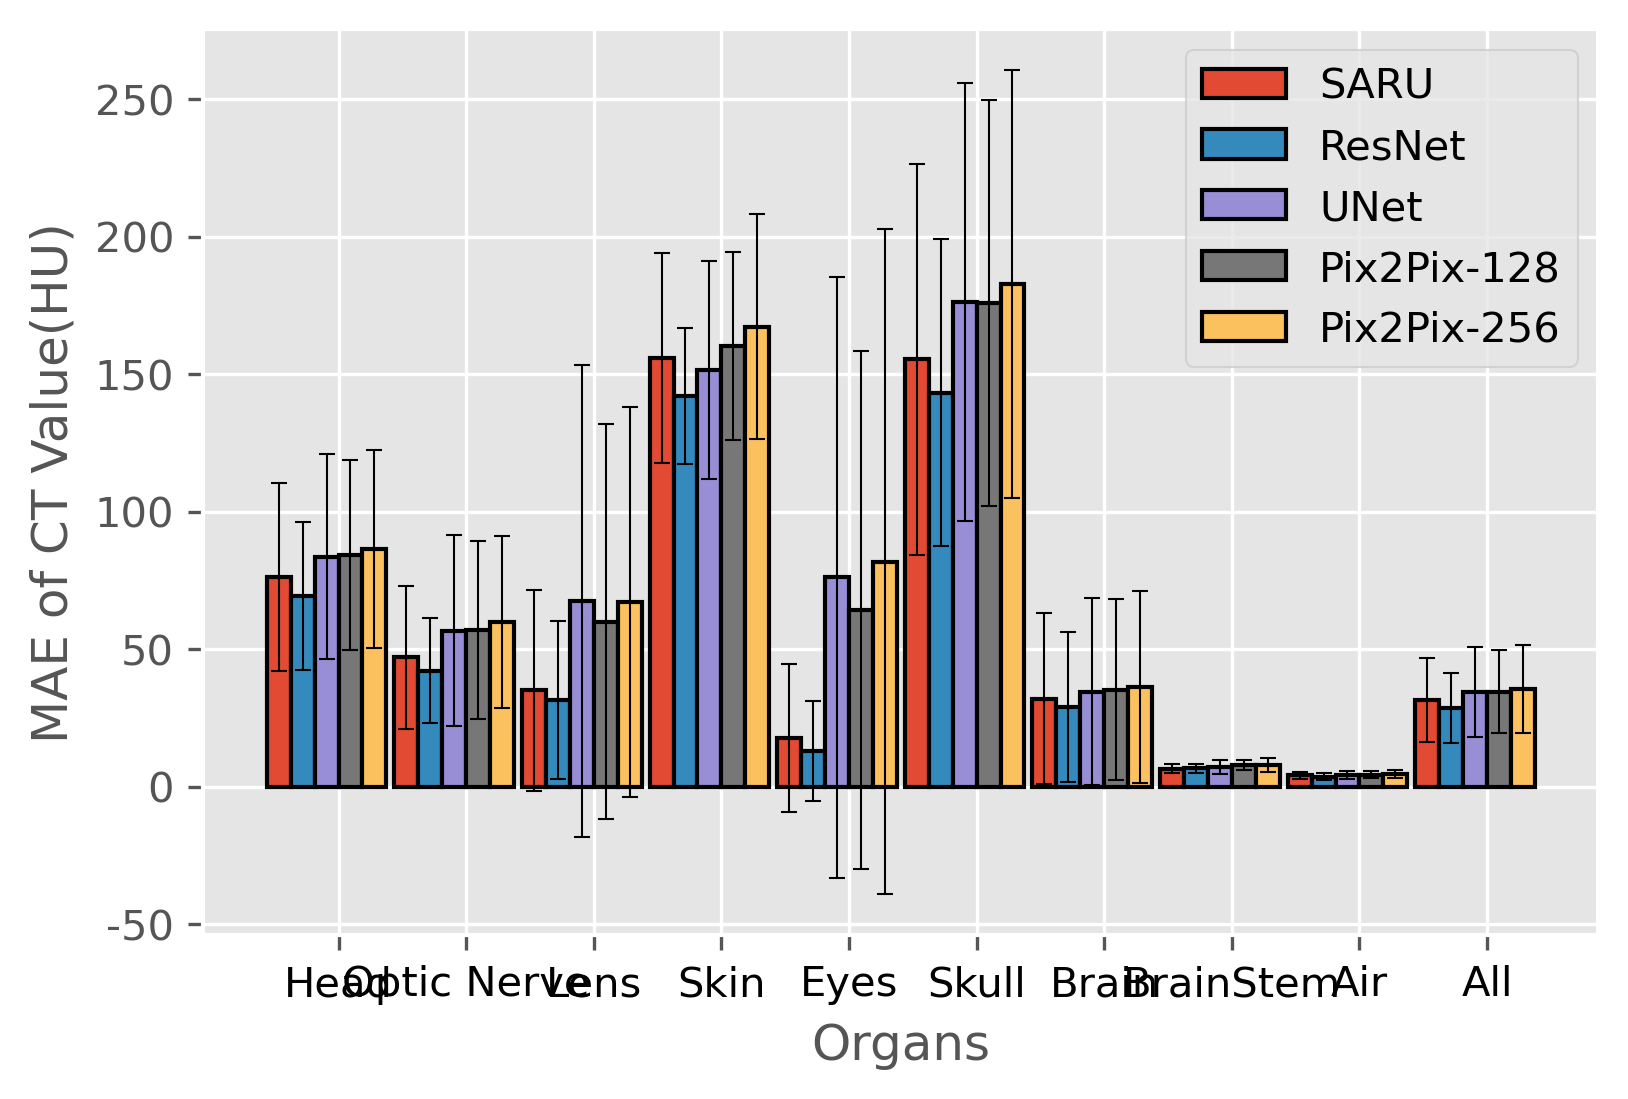

In [7]:
def sortbymae(x):
    return x[1]
# sorted([_info for _info in all_data if _info[0]=='mae' and _info[3]=='Head'  and _info[2]=='SARU'],key=sortbymae)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['hatch.linewidth'] = 0.5  # previous svg hatch linewidth
plt.style.use('ggplot')

df = pd.read_csv('./result.csv',sep= ',',
    error_bad_lines= False,
    names = ['Type', 'Value','Backbone',"Organ","Pid"],
    na_values= 'NULL')

organs_list = set(df["Organ"])
print(organs_list)
total_width, n = len(backbones)*0.2, len(backbones)
plt.figure(dpi=300)
gap=len(backbones)*0.2*1.2
X=np.linspace(-2*gap,len(organs_list)*gap,len(organs_list))

for backbone in backbones:
    net_name = labels[backbone]
    
    mean_value_list = []
    std_value_list = []
    
    for organ in set(df["Organ"]):
        _df = df[(df["Backbone"]==net_name) & (df["Type"]=="mae") & (df["Organ"]==organ)]
        _df = _df[~df['Pid'].isin([3,99,33,136,11,86,77,102,16,22])]  # ['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']  # 110,114,112,85,91,5,43,46,68,102,
        # print()
        values = _df["Value"]
        mean = np.mean(values)
        mean_value_list.append(mean)
        std = np.std(values)
        std_value_list.append(std)
        print(f"{net_name} {organ}: {mean:.2f}±{std:.2f}")
    
    
    
    plt.bar(X, #每个柱子的名称
            mean_value_list,# year_2019, #每个柱子的高度
            #bottom=0, #柱子起始位置对应纵坐标， 默认从0开始
            #align='edge',# 柱子名称位置，默认'center',可选'edge'
#                 color="red",
            edgecolor='black',
            # _type,
            linewidth=1,
            error_kw=dict(lw=0.5, capsize=2, capthick=0.5),
            #tick_label=['Brain', 'Brain Stem', 'CTV', 'Inner Ear'], #自定义每个柱子的名称
            yerr=std_value_list,#添加误差棒
            #ecolor='red',#误差棒颜色，默认黑色
            #capsize=2, #误差棒上下的横线长度
            log=False,#y轴坐标取对数
            width=0.3,
            label=net_name,
           )
    X+=0.3
plt.xticks(np.array(X)-0.75 ,set(df["Organ"]),color='black',rotation=0)
plt.legend()
plt.xlabel(r"Organs")
plt.ylabel(r"MAE of CT Value(HU)")
#plt.savefig("/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/pics/organ_MAE.png")
plt.show()

## Visulaze

In [11]:
import ants
result_niis_path = "/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/fake_ct_niis/"
real_niis_path = "/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/real_ct_niis_0327/"
TEST_LIST = ["033","077"]#["021","023","117"]#"021","023",#['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']#['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']
for pid,pn in enumerate(TEST_LIST,1):
    print(pid)
    real_path = os.path.join(real_niis_path,f"{pn}.nii")
    img = ants.image_read(real_path)
    img += 1000
    img.plot(slices=[30,40,50,60,70,80,90,100,110],title=f"Patient:{pn} Real",dpi=600,filename=f"./result_nii_pngs/real_{pn}_0.png")
    img.plot(slices=[30,40,50,60,70,80,90,100,110],axis=1,title=f"Patient:{pn} Real",dpi=600,filename=f"./result_nii_pngs/real_{pn}_1.png")
    img.plot(axis=2,slices=[3,5,7,9,11,13,15,16,17],dpi=200,title=f"Patient:{pn} Real",filename=f"./result_nii_pngs/real_{pn}_2.png")
    for net_name in backbones:
        img_path = os.path.join(result_niis_path,f"{net_name}_{pn}.nii")
       
        img = ants.image_read(img_path)
        img += 1000
        
        img.plot(slices=[30,40,50,60,70,80,90,100,110],dpi=600,title=f"Patient:{pn} {labels[net_name]}",filename=f"./result_nii_pngs/{net_name}_{pn}_0.png")
        img.plot(slices=[30,40,50,60,70,80,90,100,110],axis=1,dpi=600,title=f"Patient:{pn} {labels[net_name]}",filename=f"./result_nii_pngs/{net_name}_{pn}_1.png")
        img.plot(axis=2,slices=[3,5,7,9,11,13,15,16,17],dpi=200,title=f"Patient:{pn} {labels[net_name]}",filename=f"./result_nii_pngs/{net_name}_{pn}_2.png")

1


ValueError: File /home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/fake_ct_niis/saru_r1_003_033.nii does not exist!

### Boxplot

In [1]:
import seaborn as sns
plt.style.use('ggplot')
plt.figure(dpi=400,figsize=(10,5))
# plt.title("MAE Result of all Val Patients")
# data=pd.DataFrame(all_data,columns=['Type', 'MAE(HU)','Backbone',"Organ","Pid"])#"Patient"
data = pd.read_csv('./result.csv',sep= ',',
    error_bad_lines= False,
    names = ['Type', 'MAE(HU)','Backbone',"Organ","Pid"],
    na_values= 'NULL')
# print(data)
data[data["Backbone"]=="SARU"] = "resnet"
data[data["Backbone"]=="ResNet"] = "SARU"
data2=data[data["Type"]=="mae"]
# data2= data2[~ data2['Pid'].isin([110,114,112,85,91,5,43,46,68,102])]
data2= data2[~ data2['Pid'].isin([3,99,33,136,11,86,77,102,16,22])]  # ['003', '099', '033', '136', '011', '086', '077', '102', '016', '022']  # 110,114,112,85,91,5,43,46,68,102,
box_plot = sns.boxplot(y='MAE(HU)',x= 'Organ',hue="Backbone",data=data2,showfliers =False,order=["Lens","Optic Nerve","Eyes","BrainStem","Brain","Skull","Head","Air","All","Skin"]
                      )#,hue_order=["SARU","ResNet","UNet","Pix2Pix"]
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()
for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    colors = ["#cc5a49","#4586ac","#9e97cc","#777777"]
    for index in range(4):
        y = round(lines[4+cat*20+index*5].get_ydata()[0],1)
        y_pos = round(lines[3+cat*20+index*5].get_ydata()[0],1)+10
        x = round(lines[4+cat*20+index*5].get_xdata()[0],1)+0.1
        ax.text(
            x, 
            y_pos, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='bold', 
            size=5,
            color=colors[index],
            # bbox=dict(facecolor='#445A64')
        )
box_plot.figure.tight_layout()
plt.savefig("./organ_mae_boxplot.png")

NameError: name 'plt' is not defined

## Check Dose result

In [9]:
test_file = "/home/zhaosheng/paper2/online_code/response/dose_results/pix2pix_128_r1_003_boron10.csv"
import numpy as np
def _array_from_MC(MC_OUT_FILE,mode="txt",reload=False,redundancy=True):
    """Get a two-dimensional numpy array from the output file
        of Monte Carlo software.

    Args:
        MC_OUT_FILE ([str]): [The path to the output file]
    Returns:
        [array]: [The result of this output file in a two-dimensional array format]
    """
    if mode == "txt":
        if (not reload) and os.path.exists(MC_OUT_FILE[:-4]+".npy"):
            filename_ = MC_OUT_FILE[:-4]+".npy"
            print(f"\t->Loading npy file : {filename_}")
            array_ = np.load(filename_)
            print(f"\t->Shape:{array_.shape}")
            return array_
        print(f"\t->Reading MC output file : {MC_OUT_FILE}")
        with open(MC_OUT_FILE,encoding = 'utf-8') as f:
            data = np.loadtxt(f,delimiter = ",", skiprows = 8)
        output = data[:,3].reshape(256,256,-1)
        np.save(MC_OUT_FILE[:-4],output)
        if redundancy:
            print(f"\t->Saving MC output file : {MC_OUT_FILE}")
            print(f"\t->Shape:{output.shape}")
        return output

In [10]:
dose_array = _array_from_MC(test_file)

	->Loading npy file : /home/zhaosheng/paper2/online_code/response/dose_results/pix2pix_128_r1_003_boron10.npy
	->Shape:(256, 256, 22)


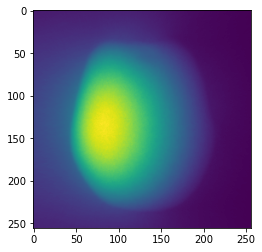

In [3]:
import numpy as np

seg_path = "/home/zhaosheng/paper2/online_code/cbamunet-pix2pix/results/seg"
dose_csv_path = "/home/zhaosheng/paper2/online_code/response/raw_dose_results"


def _array_from_MC(MC_OUT_FILE,mode="txt",reload=False,redundancy=True):
    """Get a two-dimensional numpy array from the output file
        of Monte Carlo software.

    Args:
        MC_OUT_FILE ([str]): [The path to the output file]
    Returns:
        [array]: [The result of this output file in a two-dimensional array format]
    """
    if mode == "txt":
        if (not reload) and os.path.exists(MC_OUT_FILE[:-4]+".npy"):
            filename_ = MC_OUT_FILE[:-4]+".npy"
            print(f"\t->Loading npy file : {filename_}")
            array_ = np.load(filename_)
            print(f"\t->Shape:{array_.shape}")
            return array_
        print(f"\t->Reading MC output file : {MC_OUT_FILE}")
        with open(MC_OUT_FILE,encoding = 'utf-8') as f:
            data = np.loadtxt(f,delimiter = ",", skiprows = 8)
        output = data[:,3].reshape(256,256,-1)
        np.save(MC_OUT_FILE[:-4],output)
        if redundancy:
            print(f"\t->Saving MC output file : {MC_OUT_FILE}")
            print(f"\t->Shape:{output.shape}")
        return output

# if __name__ == "__main__":
#     csvs = sorted([os.path.join(dose_csv_path,_file) for _file in os.listdir(dose_csv_path) if ".csv" in _file])
#     print(f"find #{len(csvs)} csv file.")
#     for csv_file in csvs:
#         try:
#             _array_from_MC(csv_file)
#         except Exception as e:
#             print(f"Error!! {csv_file}")
#             print(e)

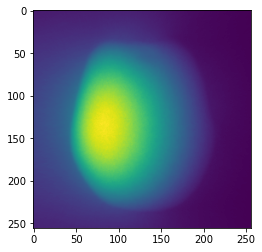

In [5]:
import matplotlib.pyplot as plt
import numpy as np
dose_array = np.load(os.path.join(dose_csv_path,"pix2pix_128_r1_003_boron10.npy"))
plt.imshow(dose_array[:,:,10])

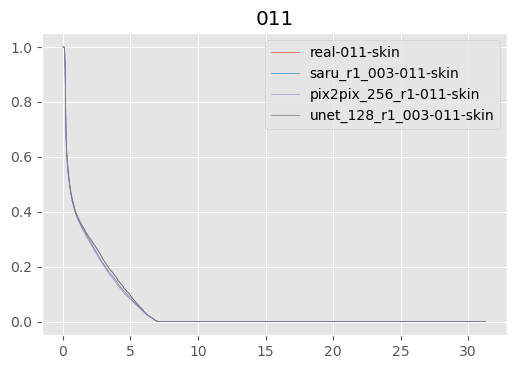

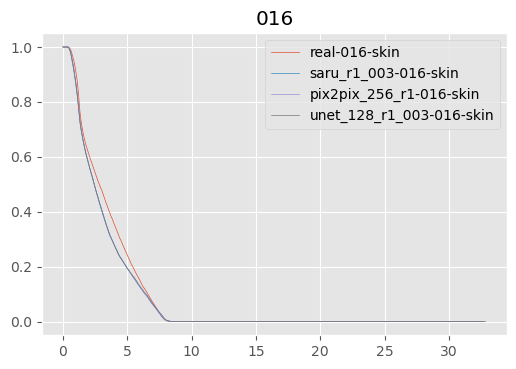

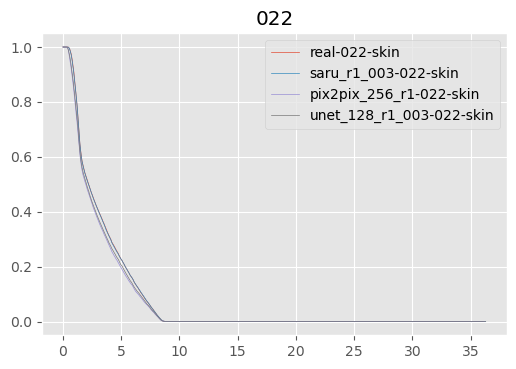

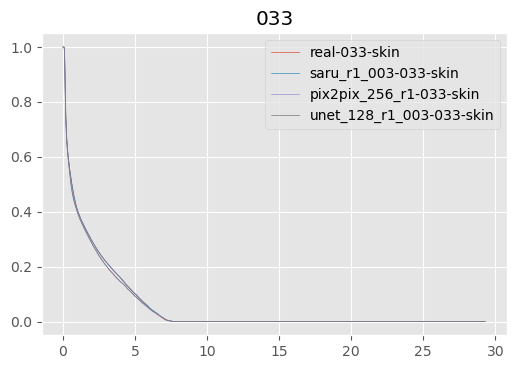

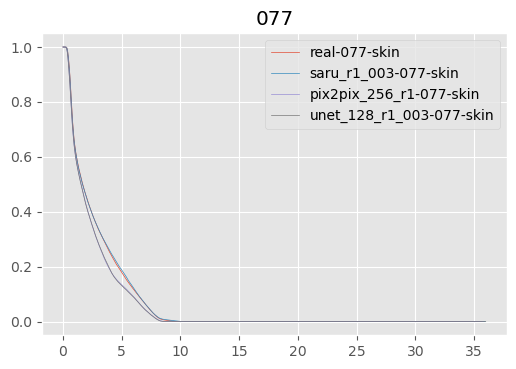

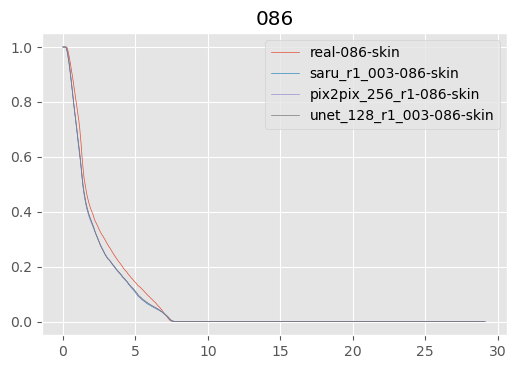

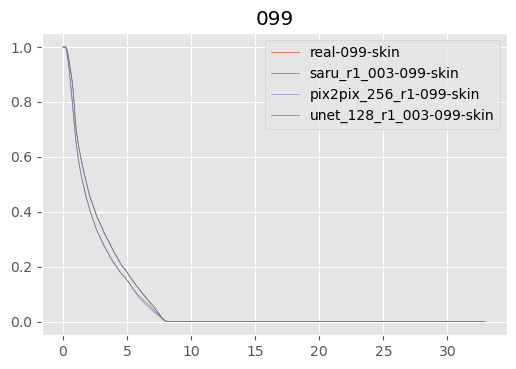

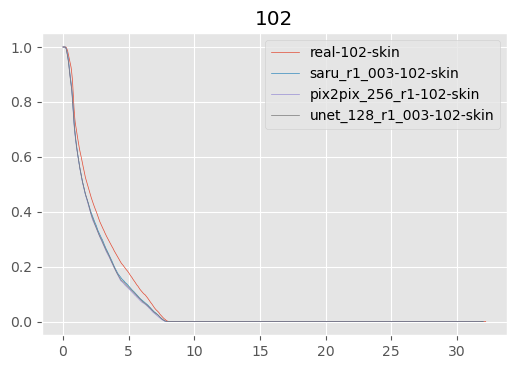

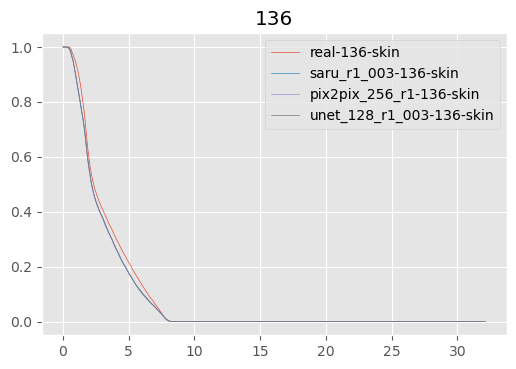

In [9]:
import numpy as np
# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pnames = ["011","016","022","033","077","086","099","102","136"]#"003",
organ_list = ["len_l","len_r","gtv","brain","brainstem","skull","on_l","on_r","eye_l","eye_r","skin"]
nets = ["real","saru_r1_003","pix2pix_256_r1","unet_128_r1_003"] # "resnet_r1","real"]#,"resnet_r1","pix2pix_256_r1","pix2pix_128_r1","unet_128_r1_003"
# pname = "011"
for pname in pnames:
    plt.figure(dpi=100,figsize=(6,4))
    for net in nets:

        a = np.load(f"/home/zhaosheng/paper2/online_code/response/dvh/{pname}_{net}_dvh_info.npy",allow_pickle=True)
        for data in a:
            if data["organ"] == 'skin':
                plt.plot(data["x"],data["y"],label=f"{data['net']}-{data['pname']}-{data['organ']}",linewidth=0.5)
                # plt.plot(data["x"],data["y"],label=f"{data['net']}-{data['pname']}-{data['organ']}",linewidth=0.5)
            # break
    plt.legend()
    plt.title(pname)
    plt.savefig("a.png")
    plt.show()
